In [105]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [106]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from sklearn import decomposition
from events import get_event_periods
from psth import get_spike_counts

np.set_printoptions(suppress=True)

In [107]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [108]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009266.keys()]
sessions.sort()
#sessions = selected_57[14:]
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [109]:
session = sessions[13]
#session = '009265_hippoSIT_2023-03-02_16-27-42'
session

'009266_hippoSIT_2023-05-23_09-18-05'

In [110]:
# reading datasets
animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
units_file = os.path.join(source, animal, session, 'units.h5')
perio_file = os.path.join(source, animal, session, 'analysis', 'metronome', 'periods.h5')
#desc_file  = os.path.join(source, animal, session, 'descendants.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    sound_events = np.array(f['processed']['sound_events'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = [name for name in f if int(name[0]) < 3]
    for unit_name in unit_names:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        
with h5py.File(perio_file, 'r') as f:
    periods = np.array(f['periods'])
    prof_idxs = np.array(f['prof_idxs'])
    test_idxs = np.array(f['test_idxs'])

In [111]:
#unit_names = np.random.choice(unit_names, int(len(unit_names)/2), replace=False)
#unit_names = unit_names[:49]
#unit_names

In [112]:
prof_idxs, test_idxs

(array([ 2, 21,  7, 12, 13, 19, 30,  4, 37, 36,  5, 38, 10, 23,  0, 25, 32,
        31,  1, 22]),
 array([ 3,  6,  8,  9, 11, 14, 15, 16, 17, 18, 20, 24, 26, 27, 28, 29, 33,
        34, 35, 39, 40]))

## Response profile matrix (no stimulus)

In [113]:
def get_pop_resp_profile_mx(source, session, unit_names, hw, bc):
    animal      = session.split('_')[0]
    psth_file   = os.path.join(source, animal, session, 'analysis', 'metronome', 'psth.h5')
    #shuf_file   = os.path.join(source, animal, session, 'analysis', 'metronome', 'shuffle.h5')
    shuf_file   = os.path.join(source, animal, session, 'analysis', 'shuffle_micro.h5')
    
    bins = np.linspace(-hw, hw, bc)
    profile_mx = np.zeros([len(unit_names), bc - 1])
    shuffle_mx = np.zeros([len(unit_names), bc - 1])
    for i, unit_name in enumerate(unit_names):
        with h5py.File(psth_file, 'r') as f:
            psths = np.array(f[unit_name]['profile_stats'])
        with h5py.File(shuf_file, 'r') as f:
            shuffled = np.array(f['SIL'][unit_name]['shuffled'])
            
        fr_mean = shuffled[1]
        fr_std  = shuffled[2]
        fr_prof = psths[1]
        #profile_mx[i] = (fr_prof - fr_mean)/fr_std  # z-scored
        profile_mx[i] = fr_prof
        shuffle_mx[i] = fr_mean
        
    return profile_mx, bins, shuffle_mx

In [114]:
def get_pop_resp_profile_mx_all(source, session, unit_names, hw, bc):
    animal      = session.split('_')[0]
    psth_file   = os.path.join(source, animal, session, 'analysis', 'psth_micro.h5')
    shuf_file   = os.path.join(source, animal, session, 'analysis', 'shuffle_micro.h5')
            
    bins = np.linspace(-hw, hw, bc)
    profile_mx = np.zeros([len(unit_names), bc - 1])
    shuffle_mx = np.zeros([len(unit_names), bc - 1])
    for i, unit_name in enumerate(unit_names):
        with h5py.File(psth_file, 'r') as f:
            psths = np.array(f['SIL'][unit_name]['profile_stats'])
        with h5py.File(shuf_file, 'r') as f:
            shuffled = np.array(f['SIL'][unit_name]['shuffled'])
            
        fr_mean = shuffled[1]
        fr_std  = shuffled[2]
        fr_prof = psths[1]
        profile_mx[i] = (fr_prof - fr_mean)/fr_std  # z-scored
        #profile_mx[i] = fr_prof
        shuffle_mx[i] = fr_mean
        
    return profile_mx, bins, shuffle_mx

In [115]:
hw, bc = 0.25, 31
profile_mx_split, bins_prof, s_mx_prof = get_pop_resp_profile_mx(source, session, unit_names, hw, bc)
profile_mx_full, bins_prof, s_mx_full = get_pop_resp_profile_mx_all(source, session, unit_names, hw, bc)

profile_mx_half = profile_mx_split[:, 15:]
#profile_mx_half = profile_mx_full[:, 15:]

# shuffle responses
# pr_T = profile_mx_half.T
# np.random.shuffle(pr_T)
# profile_mx_half = pr_T.T

# shuffle independently
shuffled = np.zeros(profile_mx_half.shape)
for i, prof in enumerate(profile_mx_half):
    p1 = prof.copy()
    np.random.shuffle(p1)
    shuffled[i] = p1

profile_mx_half.shape

(65, 15)

In [116]:
#sort_index = np.argsort(first_sign_bins)
#profile_mx_half_s = profile_mx_half[sort_index]

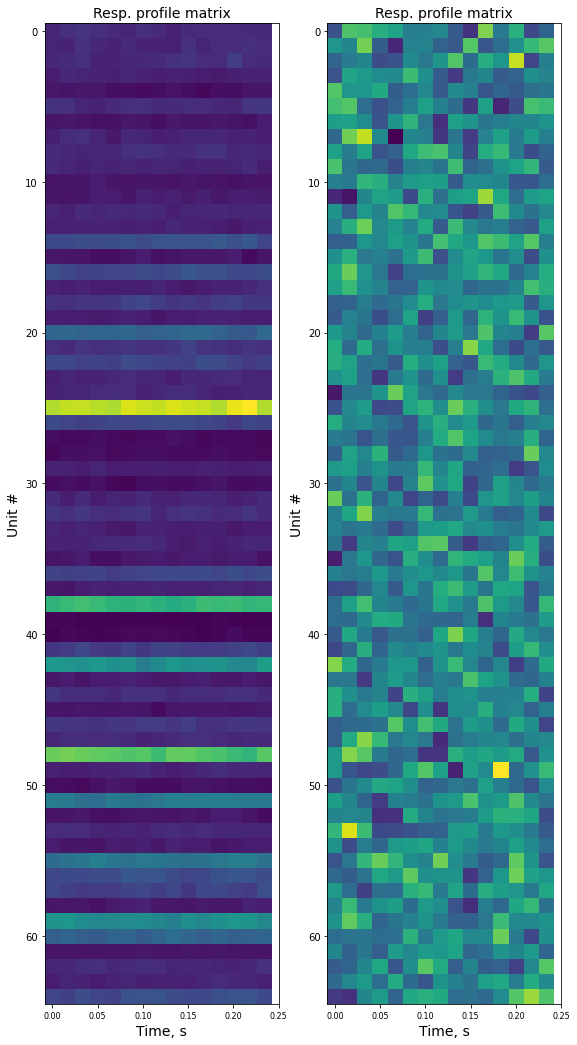

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(8, 15))

for i, p_mx in enumerate([profile_mx_split, profile_mx_full]):
    ax = axes[i]
    ax.imshow(p_mx[:, 15:])
    ax.set_xlabel('Time, s', fontsize=14)
    ax.set_ylabel('Unit #', fontsize=14)
    ax.set_xticks(np.arange(len(bins_prof[15::3]))*3)
    _ = ax.set_xticklabels(["%.2f" % b for b in bins_prof[15::3]], fontsize=8)
    ax.set_title("Resp. profile matrix", fontsize=14)

fig.tight_layout()
#fig.savefig(os.path.join(report, 'Hall', 'response_profile_matrix_small.png'), dpi=500)

In [118]:
idxs_unit_corr = []
for i in range(len(profile_mx_split)):
    if np.corrcoef(profile_mx_full[i], profile_mx_split[i])[0][1] > 0.05:
        idxs_unit_corr.append(i)
idxs_unit_corr = np.array(idxs_unit_corr)
len(profile_mx_full), len(idxs_unit_corr)

(65, 65)

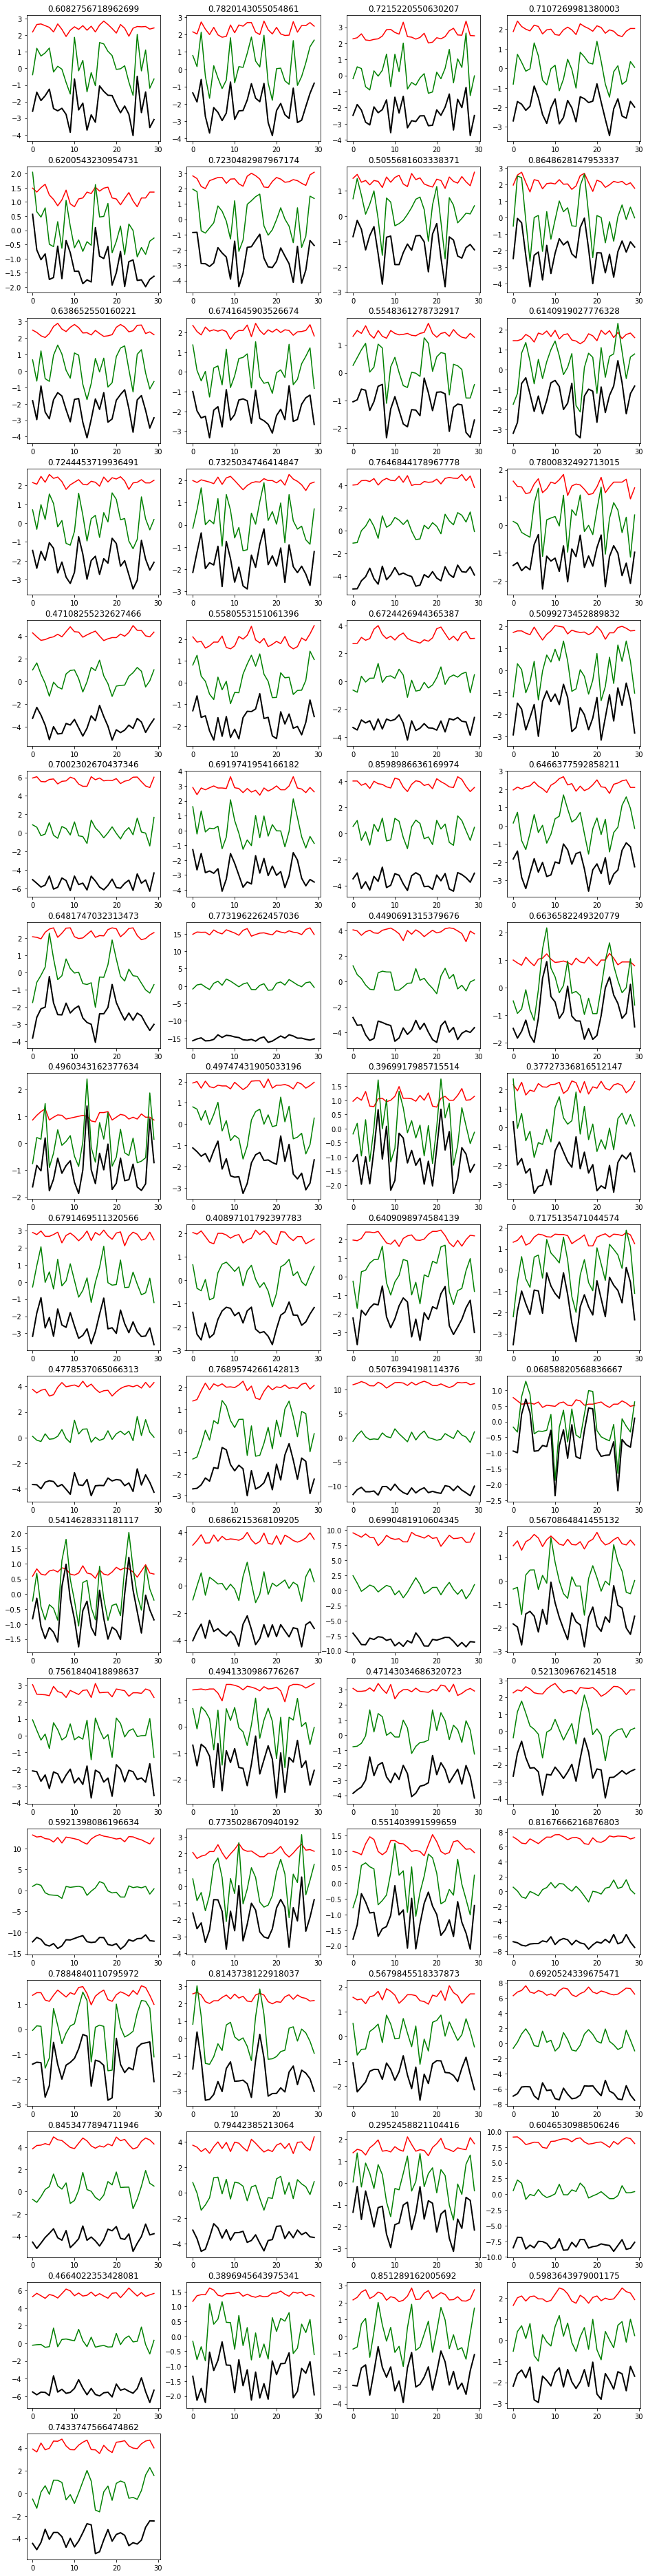

In [119]:
cols = 4
rows = int(np.ceil(len(profile_mx_split)/cols))
fig = plt.figure(figsize=(4*cols, 4*rows))

for i in range(len(profile_mx_split)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.plot(profile_mx_split[i], color='red')
    #ax.plot(s_mx_prof[i], color='red')
    ax.plot(profile_mx_full[i], color='green')
    #ax.plot(s_mx_full[i], color='green')
    ax.plot(profile_mx_full[i] - profile_mx_split[i], color='black', lw=2)
    cf = np.corrcoef(profile_mx_full[i], profile_mx_split[i])[0][1]
    ax.set_title(cf)

## 2.2 Unit activity matrix for selected periods (overlayed)

In [120]:
event_type = 0  # no stimulus
periods_test = periods[test_idxs]
#periods_test = periods

# overlayed unit activity matrix - binning
bin_size = hw / ((bc-1)/2)
bc_amx   = int(30*(1/bin_size))  # 30 secs
bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx+1)
unit_amx = np.zeros([len(unit_names), len(bins_amx) - 1])

# fill in the unit AM
for i, unit_name in enumerate(unit_names):
    strain = spike_times[unit_name]

    strain_overlayed = []
    for period in periods_test:
        spikes = strain[(strain > period[0]) & (strain < period[1])]
        spikes -= period[0]  # align to time 0
        strain_overlayed.append(spikes)
        
    # flatten
    strain_over_flat = np.array([item for sublist in strain_overlayed for item in sublist])
    strain_over_flat = np.sort(strain_over_flat)
    
    # convert overlayed spike times into binned spike counts
    spikes_binned, _ = np.histogram(strain_over_flat, bins=bins_amx)
    spikes_binned = stats.zscore(spikes_binned)  # z-scored!!
    unit_amx[i] = spikes_binned

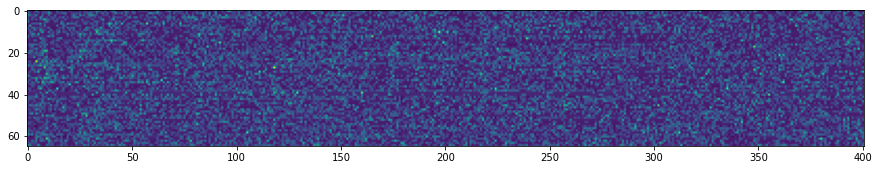

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.imshow(unit_amx[:, 0:401])

## CCR Matrix and analysis

In [122]:
# CCR matrix for all units
CCR_amx = np.zeros(unit_amx.shape)
for unit_idx in range(len(profile_mx_half)):
    prof = profile_mx_half[unit_idx]
    spks = unit_amx[unit_idx]
    #spks = unit_AM_shuf[unit_idx]
    CCR_amx[unit_idx] = signal.correlate(spks, prof, mode='same')

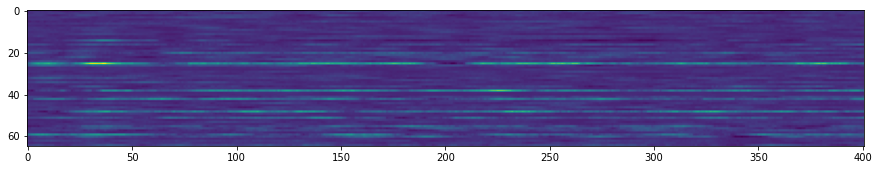

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.imshow(CCR_amx[:, 0:401])

In [124]:
# fake pulsetrain
pulse_times = np.linspace(0, 30, 30*4+1) + 0.11  # half a period to align nicely
do_PCA = False

# original and transformed signals
unit_sig = unit_amx[idxs_unit_corr].mean(axis=0)

if do_PCA:
    pca = decomposition.PCA(n_components=3)
    pca.fit(CCR_amx.T)
    X = pca.transform(CCR_amx.T)
    ccr_sig = X[:, 0]  # PC1 score
else:
    ccr_sig = CCR_amx[idxs_unit_corr].mean(axis=0)
            
# filter out low freq noise
low_cut, high_cut = 1, 29  # Hz
s_rate = 60
sos = signal.butter(10, [low_cut / (0.5*s_rate), high_cut/(0.5*s_rate)], analog=False, btype='band', output='sos')
ccr_sig_filt  = signal.sosfiltfilt(sos, ccr_sig)
unit_sig_filt = signal.sosfiltfilt(sos, unit_sig)

(0.0, 20.0)

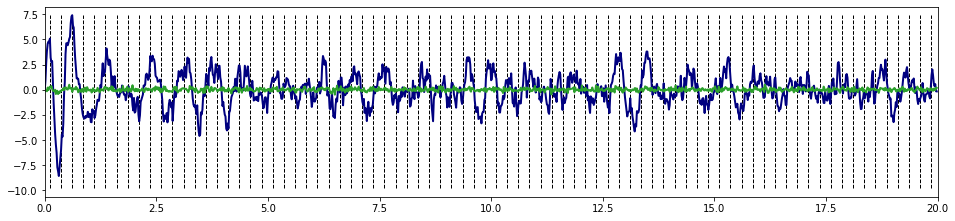

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3.5))

idx_l, idx_r = 0, 1200
ax.plot(bins_amx[idx_l:idx_r], ccr_sig_filt[idx_l:idx_r], color='navy', lw=2, label='Transformed')
ax.plot(bins_amx[idx_l:idx_r], unit_sig_filt[idx_l:idx_r], color='tab:green', lw=2, label='Original')
ax.vlines(pulse_times, ccr_sig_filt.min(), ccr_sig_filt.max(), color='black', lw=1, ls='--', label='"Fake" stim.')
ax.set_xlim(bins_amx[idx_l], bins_amx[idx_r])

(700.0, 1100.0)

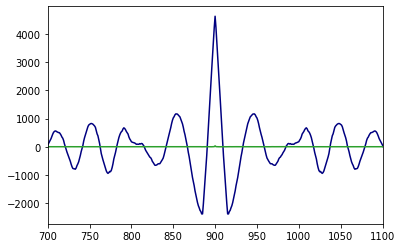

In [126]:
autocorr_CCR  = signal.correlate(ccr_sig_filt, ccr_sig_filt, mode='same')
autocorr_unit = signal.correlate(unit_sig_filt, unit_sig_filt, mode='same')
x_l, x_r = int(len(autocorr_CCR)/2) - 200, int(len(autocorr_CCR)/2) + 200

fig, ax = plt.subplots(1, 1)
ax.plot(autocorr_CCR, color='navy')
ax.plot(autocorr_unit, color='tab:green')
ax.set_xlim(x_l, x_r)

In [127]:
def get_power_spectrum(sig, s_rate=1000):
    FFT = np.fft.fft(sig)
    nyquist = s_rate / 2
    freqs = np.linspace(0, nyquist, int(len(sig)/2))
    half_FFT = FFT[:len(freqs)]
    complex_conjugate = np.conj(half_FFT)
    return freqs, half_FFT*complex_conjugate

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Power')

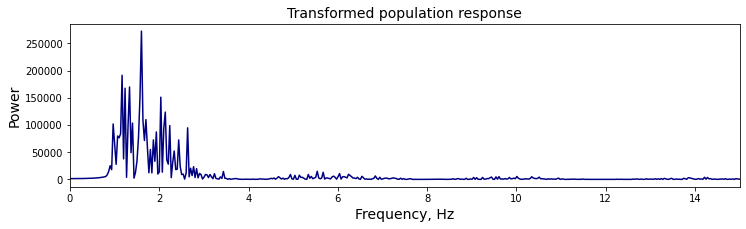

In [128]:
bl, br = 0, 1200  # range in bins to compute FFT

# population activity spectrum
freqs, powers = get_power_spectrum(ccr_sig_filt, s_rate=s_rate)  # first 20 secs

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

# power of the metronome
ax.plot(freqs, powers, color='navy')
ax.set_title('Transformed population response', fontsize=14)
ax.set_xlim(0, 15)
ax.set_xlabel('Frequency, Hz', fontsize=14)
ax.set_ylabel('Power', fontsize=14)